In [1]:
from shared.preface import *
import shared.functions as fct

import scipy.stats as stat

def bin_volumes(radial_bins):
    """Returns the volumes of the bins. """

    single_vol = lambda x: (4.0 / 3.0) * np.pi * x ** 3
    outer = single_vol(radial_bins[1:])
    inner = single_vol(radial_bins[:-1])
    return outer - inner


def bin_centers(radial_bins):
    """Returns the centers of the bins. """

    outer = radial_bins[1:]
    inner = radial_bins[:-1]
    return 0.5 * (outer + inner)


def analyse_halo(mass, pos):
    # Define radial bins [log scale, kpc units]
    radial_bins = np.arange(0, 5, 0.1)
    radial_bins = 10 ** radial_bins

    # Radial coordinates [kpc units]
    r = np.sqrt(np.sum(pos ** 2, axis=1))

    SumMasses, _, _ = stat.binned_statistic(
        x=r, values=np.ones(len(r)) * mass[0], 
        statistic="sum", bins=radial_bins
    )
    density = (SumMasses / bin_volumes(radial_bins))  # Msun/kpc^3
    return density

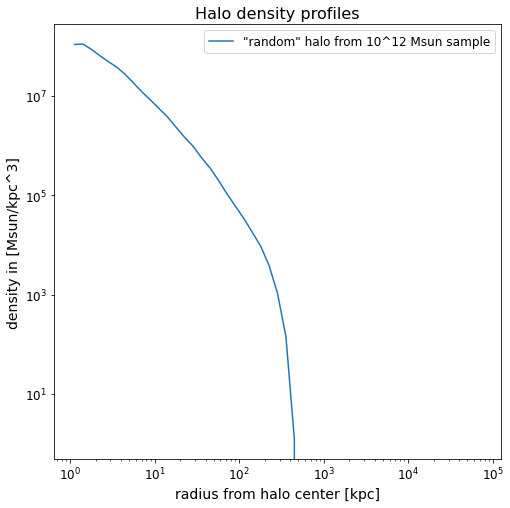

In [18]:
def extract_density_profile_1halo(
    which_halos, mass_select, mass_range=0.2, snap_num='0036'
    ):

    # Open data files.
    folder = SIM_DATA
    snaps = h5py.File(f'{folder}/snapshot_{snap_num}.hdf5')
    group = h5py.File(f'{folder}/subhalo_{snap_num}.catalog_groups')
    parts = h5py.File(f'{folder}/subhalo_{snap_num}.catalog_particles')
    props = h5py.File(f'{folder}/subhalo_{snap_num}.properties')

    ### Properties of DM particles.

    # Positions.
    a = snaps["/Header"].attrs["Scale-factor"]
    pos = snaps['PartType1/Coordinates'][:][:] * a  
    #! comoving to physical (pc) with a, then *1e3 to go to kpc

    # Masses.
    mass = snaps['PartType1/Masses'][:] * 1e10  
    #! some choice of Camila, *1e10 to get to Msun. All DM particles have same mass.

    # Velocities.
    vel = snaps['PartType1/Velocities'][:][:]  #! in km/s, physical

    # NFW concentration parameter.
    cNFW = props['cNFW_200crit'][:]

    # Virial radius.
    rvir = props['R_200crit'][:] *1e3 # now in kpc
    
    # Critical M_200.
    m200c = props['Mass_200crit'][:] * 1e10  # now in Msun

    # Set neg. values to 1, i.e. 0 in np.log10.
    m200c[m200c <= 0] = 1

    # This gives exponents of 10^x, which reproduces m200c vals.
    m200c = np.log10(m200c)  

    # Center of Potential coordinates, for all halos.
    CoP = np.zeros((len(m200c), 3))
    CoP[:, 0] = props["Xcminpot"][:]
    CoP[:, 1] = props["Ycminpot"][:]
    CoP[:, 2] = props["Zcminpot"][:]

    # Select halos based on exponent, i.e. mass_select input parameter.
    select_halos = np.where(
        (m200c >= mass_select-mass_range) & (m200c <= mass_select+mass_range)
    )[0]

    # Also select the corresponding cNFW and rvir for the selected halos.
    select_cNFW = cNFW[select_halos]
    select_rvir = rvir[select_halos]

    # Selecting subhalos or halos.
    subtype = props["Structuretype"][:]
    if which_halos == 'subhalos':
        select = np.where(subtype[select_halos] > 10)[0]
        select_halos = select_halos[select]
    else:
        select = np.where(subtype[select_halos] == 10)[0]
        select_halos = select_halos[select]


    # Select 1 random halo.
    np.random.seed(SEED)
    select_random = np.random.randint(len(select_halos) - 1, size=(1))
    rand_halo = select_halos[select_random]

    # Also select again corresponding cNFW and rvir to that "random" halo.
    rand_cNFW = select_cNFW[select_random]
    rand_rvir = select_rvir[select_random]

    # Grab the start position in the particles file to read from
    halo_start_pos = group["Offset"][rand_halo][0]
    halo_end_pos = group["Offset"][rand_halo + 1][0]

    particle_ids_in_halo = parts["Particle_IDs"][halo_start_pos:halo_end_pos]
    particle_ids_from_snapshot = snaps["PartType1/ParticleIDs"][...]

    # Get indices of elements, which are present in both arrays.
    _, _, indices_p = np.intersect1d(
        particle_ids_in_halo, particle_ids_from_snapshot, 
        assume_unique=True, return_indices=True
    )

    particles_mass = mass[indices_p]
    particles_pos = pos[indices_p, :]  # : grabs all 3 spatial positions.
    particles_pos -= CoP[rand_halo, :]  # centering, w.r.t halo they're part of
    particles_pos *= 1e3  # to kpc
    density_halo = analyse_halo(particles_mass, particles_pos)

    # Bin centers in kpc.
    radial_bins = 10**np.arange(0, 5, 0.1)
    centers = bin_centers(radial_bins)

    return centers, density_halo, rand_cNFW, rand_rvir


radii, densities, cNFW, rvir = extract_density_profile_1halo(
    which_halos='halos', mass_select=12
)
u1, u2 = kpc, Msun/kpc**3
radii *= u1
densities *= u2



fig = plt.figure(figsize=(8,8))

# Extracted density profile from halo.
plt.loglog(radii/u1, densities/u2, label='"random" halo from 10^12 Msun sample')

# NFW profile with NFW parameters from same halo.
rho = rho0_MW
r_s = rvir / cNFW
NFW = fct.NFW_profile(radii, rho, r_s)
# plt.loglog(radii/u1, NFW/u2, c='k', ls='-.', label='NFW')

plt.title('Halo density profiles')
plt.xlabel(f'radius from halo center [kpc]')
plt.ylabel('density in [Msun/kpc^3]')
# plt.xlim(np.min(radii/kpc), 600)
# plt.ylim(1e1, 1e9)
plt.legend()
plt.show()